Импортируем все нужные библиотеки



In [ ]:
pip install cltk

In [ ]:
import cltk

In [ ]:
from nltk.tokenize import word_tokenize
from nltk import download
download('punkt')
from nltk.tokenize.punkt import PunktLanguageVars
from nltk.util import bigrams
from nltk.util import trigrams
from nltk.util import ngrams

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from collections import Counter

Наносим грамматическую разметку, считаем распределение частеречных биграмм и записываем все в датафрейм

In [ ]:
from cltk import NLP

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
import pandas as pd

In [ ]:
name_of_txt_file = 'Bernoulli N_De motu corporum ex percussione.txt'

In [ ]:
with open(name_of_txt_file) as fo:
  livy_full = fo.read()
print(name_of_txt_file, len(livy_full))

Bernoulli N_De motu corporum ex percussione.txt 6439


In [ ]:
cltk_nlp = NLP(language="lat")
cltk_nlp.pipeline.processes.pop(-1)
print(cltk_nlp.pipeline.processes)
%time cltk_doc = cltk_nlp.analyze(text=livy_full)

In [ ]:
grammar_list = []
grammar_list = cltk_doc.pos

In [ ]:
clear_grammar_list = []
for i in tqdm(grammar_list):
  if i !='PUNCT':
      clear_grammar_list.append(i)

  0%|          | 0/1169 [00:00<?, ?it/s]

In [ ]:
result = []
b = bigrams(clear_grammar_list)
result = [x for x in b]
print(len(result))

947


In [ ]:
count = Counter(result).most_common()

In [ ]:
new_item = []
for i in tqdm(count):
  a = round((i[1]/len(result))*100, 1)
  new_item.append([*i[0], i[1], a, name_of_txt_file])
new_item[:10]

  0%|          | 0/163 [00:00<?, ?it/s]

[['NOUN', 'VERB', 659, 6.1, 'Cicero_Pro Milone.txt'],
 ['NOUN', 'NOUN', 574, 5.4, 'Cicero_Pro Milone.txt'],
 ['VERB', 'VERB', 391, 3.6, 'Cicero_Pro Milone.txt'],
 ['VERB', 'NOUN', 386, 3.6, 'Cicero_Pro Milone.txt'],
 ['ADP', 'NOUN', 327, 3.1, 'Cicero_Pro Milone.txt'],
 ['PRON', 'VERB', 325, 3.0, 'Cicero_Pro Milone.txt'],
 ['VERB', 'PRON', 316, 2.9, 'Cicero_Pro Milone.txt'],
 ['ADJ', 'NOUN', 280, 2.6, 'Cicero_Pro Milone.txt'],
 ['DET', 'NOUN', 277, 2.6, 'Cicero_Pro Milone.txt'],
 ['NOUN', 'ADJ', 257, 2.4, 'Cicero_Pro Milone.txt']]

In [ ]:
for i in new_item:
  new_row = i
  df.loc[ len(df)] = new_row

In [ ]:
df = pd.DataFrame(new_item, columns=['Part of speech 1', 'Part of speech 2', 'Number of n-gramms', 'Frequency of n-gramms', 'Name of text'])

In [ ]:
print(df.nunique())

Отрисовываем график

In [ ]:
df_for_plot = df.sort_values(by='Frequency of n-gramms', ascending=False)

In [ ]:
number_lst = (list(range(0, 4161)))

In [ ]:
df_for_plot['index'] = number_lst

<ipython-input-372-3e3a3c3e68dc>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_for_plot.groupby('index').sum()['Frequency of n-gramms'].plot(label="Все грамматические биграммы")


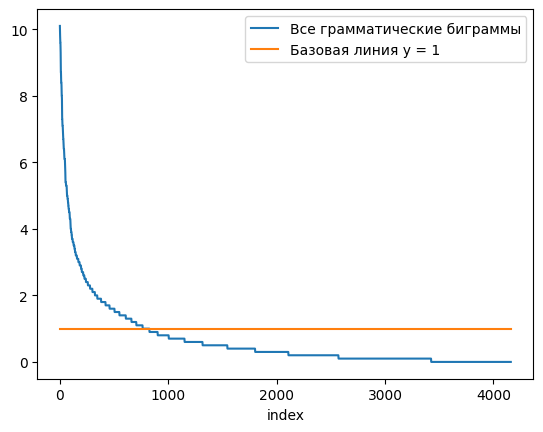

In [ ]:
import matplotlib.pyplot as plt
df_for_plot.groupby('index').sum()['Frequency of n-gramms'].plot(label="Все грамматические биграммы")
plt.plot([0, max(df.index)], [1,1], label='Базовая линия y = 1')
plt.legend()

Удаляем все биграммы с частотностью менее 1%

In [ ]:
new_df = df[df['Frequency of n-gramms'] > 1.0]

In [ ]:
len(df)

4161

In [ ]:
len(new_df)

763

In [ ]:
new_df.to_csv('grammar bigramms data.csv', index=True) #экспорт данных, далее все операции проводились с данными, импортируемыми из csv-файла

Отрисовка визуализации распределения текстов по частотности биграмм относительно друг друга

In [1]:
import numpy as np

In [3]:
import pandas as pd
dt = pd.read_csv('grammar bigramms data.csv', sep=',')

In [5]:
dt['Bigramm'] = dt[['Part of speech 1', 'Part of speech 2']].apply(lambda a:a[0]+' '+a[1],
                                                                   axis=1)

In [ ]:
dt

In [ ]:
dt[dt['Bigramm'] == 'ADJ NOUN'].sort_values("Frequency of n-gramms", ascending=False)

In [ ]:
dt['Bigramm'] = dt[['Part of speech 1', 'Part of speech 2']].apply(lambda a:a[0]+' '+a[1],
                                                                   axis=1)

In [43]:
def compare_texts(df, Name_1, Name_2):
  df_1 = df[df['Name of text'] == Name_1]
  df_2 = df[df['Name of text'] == Name_2]
  all_bigrams = set(df_1['Bigramm'].values.tolist() + df_2['Bigramm'].values.tolist())
  diffs = []
  for bigram in all_bigrams:
    sub_df_1 = df_1[df_1['Bigramm'] == bigram]
    if sub_df_1.shape[0] == 0:
      proc_1 = 0
    else:
      proc_1 = sub_df_1['Frequency of n-gramms'].values[0]
    sub_df_2 = df_2[df_2['Bigramm'] == bigram]
    if sub_df_2.shape[0] == 0:
      proc_2 = 0
    else:
      proc_2 = sub_df_2['Frequency of n-gramms'].values[0]
    diffs.append(abs(proc_1 - proc_2))
  #return sum(diffs)/len(all_bigrams)
  return np.median(diffs)

In [25]:
compare_texts(dt, 'Bayer_De muro Caucaseo.txt', 'Bayer_De muro Caucaseo.txt')

0.0

In [44]:
all_texts = dt['Name of text'].unique()
n_texts = dt['Name of text'].unique().shape[0]
m = np.zeros((n_texts, n_texts))
dists = []
for i in range(n_texts - 1):
  for g in range(i+1, n_texts):
    m[i, g] = m[g, i] = compare_texts(dt, all_texts[i], all_texts[g])
    dists.append([i, g, m[i, g]])

In [45]:
dists = np.array(dists)

In [46]:
link_info

,node1,node2,length
0,0.0,1.0,1.491825
1,0.0,2.0,1.284025
2,0.0,3.0,1.915541
3,0.0,4.0,1.648721
4,0.0,5.0,3.158193
...,...,...,...
373,24.0,26.0,2.585710
374,24.0,27.0,1.822119
375,25.0,26.0,1.822119
376,25.0,27.0,1.568312


In [47]:
link_info = pd.DataFrame(dists, columns=['node1', 'node2', 'length'])

In [48]:
def f(coords):
    all_coords = np.vstack((np.zeros((1,2)), 
                            coords.reshape((-1,2))))
    
    dists = np.linalg.norm(all_coords[link_info["node1"].values] - all_coords[link_info["node2"].values], 
                           axis=1)
    
    err = (dists - link_info["length"]) ** 2
    
    return np.sum(err)

def df(coords):
    all_coords = np.vstack((np.zeros((1,2)), 
                            coords.reshape((-1, 2))))
    dists = np.linalg.norm(all_coords[link_info["node1"].values] - all_coords[link_info["node2"].values], 
                           axis=1)
    lin_err = (dists - link_info["length"])
    
    dfs = np.zeros((len(all_coords) - 1, 2))
    for j, (xi, yi, l) in enumerate(link_info[["node1", "node2", "length"]].values):
        #print(j, xi, yi, l)
        loc_df = 2 * (dists[j] - l) * (all_coords[int(xi)] - all_coords[int(yi)]) / dists[j]
        
        if int(xi) != 0:
            dfs[int(xi) - 1] += loc_df
        if int(yi) != 0:
            dfs[int(yi) - 1] -= loc_df
            
    return dfs.reshape(-1)

from scipy.optimize import minimize

In [ ]:
min_res = minimize(f, 
                   x0=np.random.randint(-400, 400, 27 * 2).astype(float), 
                   jac=df)

In [ ]:
text_coords = np.vstack((np.zeros((1,2)), min_res.x.reshape((-1, 2))))

In [ ]:
import matplotlib.pyplot as plt

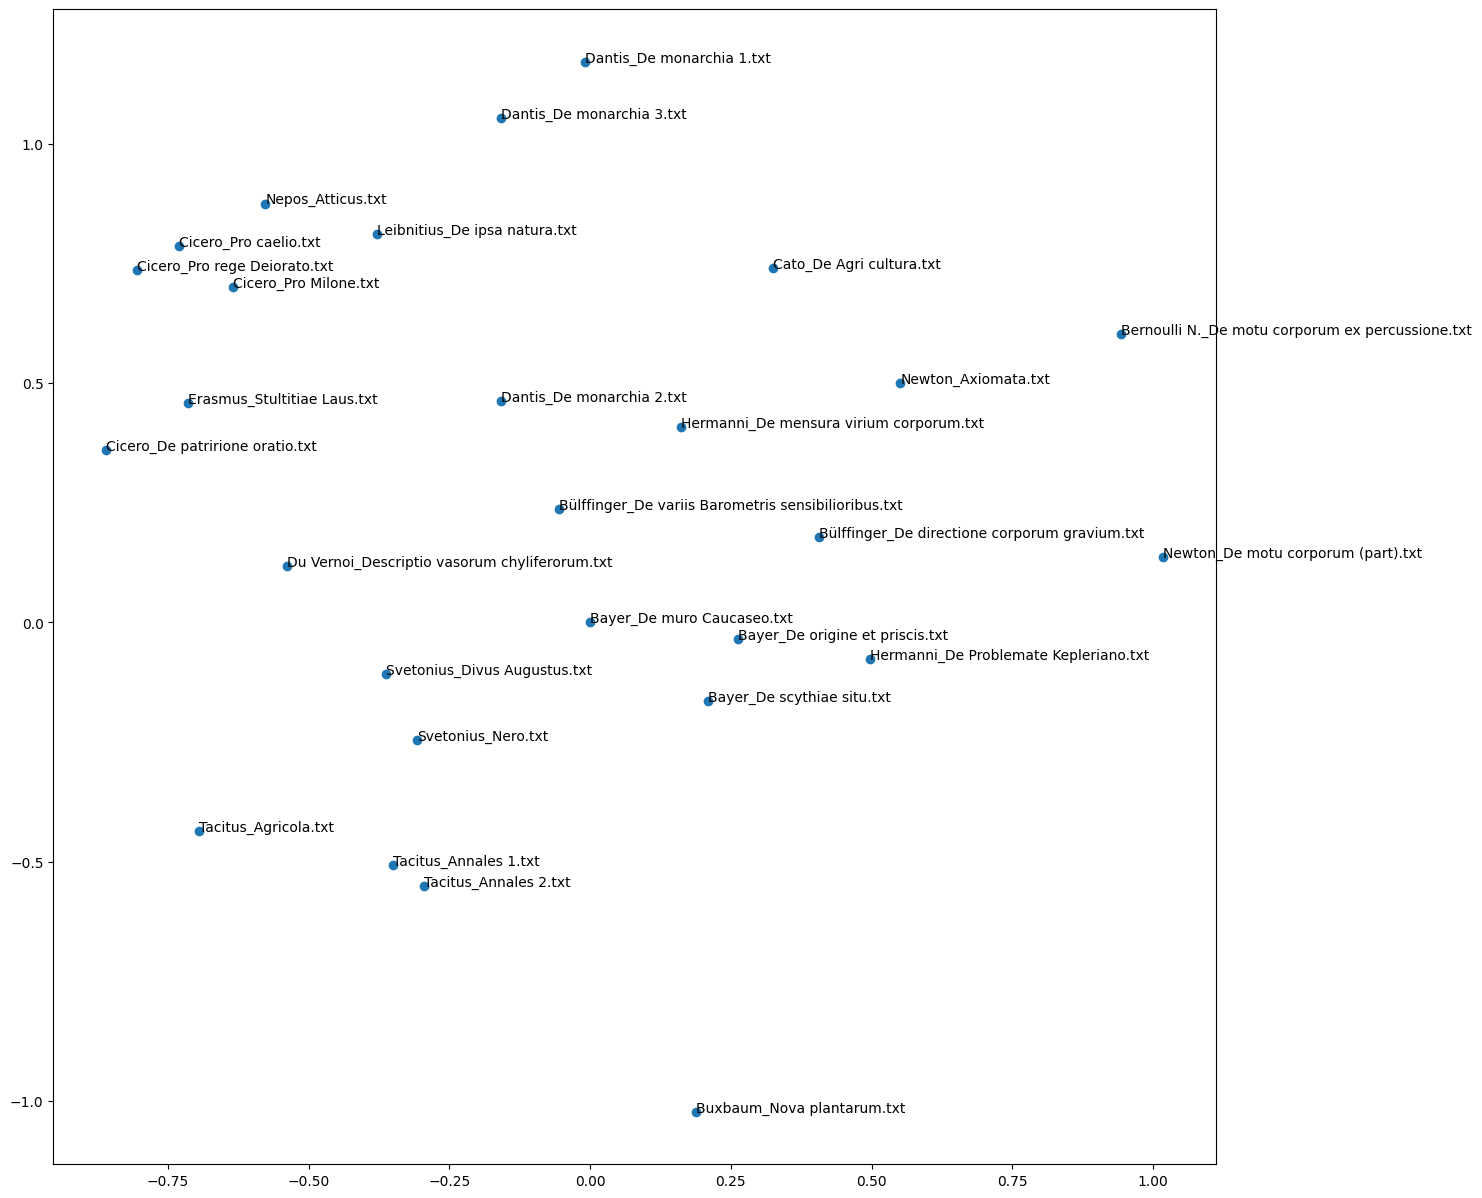

In [ ]:
_,ax=plt.subplots(1,1,figsize=(15, 15))
ax.scatter(*text_coords.T)
for i in range(len(text_coords)):
  ax.text(*text_coords[i], all_texts[i])

In [ ]:
distance_df = pd.DataFrame(m, columns=all_texts, index=all_texts)

Здесь мы смотрим на топ-1, 2, 3 и т.д. биграмм в каждом из текстов

In [ ]:
dt = pd.read_csv('grammar bigramms data.csv', sep=',')
dt

,Unnamed: 0,Part of speech 1,Part of speech 2,Number of n-gramms,Frequency of n-gramms,Name of text,Bigramm
0,0,NOUN,NOUN,659,8.5,Bayer_De muro Caucaseo.txt,NOUN NOUN
1,1,NOUN,VERB,555,7.1,Bayer_De muro Caucaseo.txt,NOUN VERB
2,2,ADP,NOUN,412,5.3,Bayer_De muro Caucaseo.txt,ADP NOUN
3,3,VERB,NOUN,290,3.7,Bayer_De muro Caucaseo.txt,VERB NOUN
4,4,ADJ,NOUN,266,3.4,Bayer_De muro Caucaseo.txt,ADJ NOUN
...,...,...,...,...,...,...,...
758,4022,VERB,AUX,129,1.2,Cicero_Pro Milone.txt,VERB AUX
759,4023,CCONJ,NOUN,128,1.2,Cicero_Pro Milone.txt,CCONJ NOUN
760,4024,ADJ,VERB,122,1.1,Cicero_Pro Milone.txt,ADJ VERB
761,4025,NOUN,ADV,122,1.1,Cicero_Pro Milone.txt,NOUN ADV


In [ ]:
def get_word(subdf, num):
    sorted_subdf = subdf.sort_values("Frequency of n-gramms", ascending=False)
    return sorted_subdf.iloc[num]

In [ ]:
top_1 = dt.groupby("Name of text").agg(get_word, 
                            num=0
                           )

In [ ]:
top_1.to_csv('top1.csv', index=True) #экспорт данных

In [ ]:
top_2 = dt.groupby("Name of text").agg(get_word, 
                            num=1
                           )

In [ ]:
top_2.to_csv('top2.csv', index=True) #экспорт данных